# **Penguins preprocessing**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seaborn import load_dataset
penguins = load_dataset("penguins")

from sklearn.model_selection import train_test_split

- Study this data set a little bit and prepare for training

In [2]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
set(penguins.iloc[:,0])

{'Adelie', 'Chinstrap', 'Gentoo'}

- Drop extra penguins

In [4]:
inds = penguins.species == 'Chinstrap'
penguins.loc[~inds].value_counts(['species', 'sex'])

species  sex   
Adelie   Female    73
         Male      73
Gentoo   Male      61
         Female    58
Name: count, dtype: int64

- Fill missed feature values and change nonnumber values

In [5]:
ds_penguins = penguins.loc[~inds].copy()
len_penguins = len(ds_penguins)

for c in ['bill_length_mm',	'bill_depth_mm',	'flipper_length_mm',	'body_mass_g']:
    ds_penguins[c] = ds_penguins[c].fillna(ds_penguins[c].median())

ds_penguins = pd.get_dummies(ds_penguins, columns=['island', 'sex'], drop_first=True)

- Split into train and test datasets

In [6]:
x_pengs_train, x_pengs_test, y_pengs_train, y_pengs_test = train_test_split( ds_penguins.drop('species', axis=1), (ds_penguins['species'] == 'Gentoo').astype(int),
    test_size=0.2, random_state=29, stratify=(ds_penguins['species'] == 'Gentoo').astype(int) )

# **Models training**

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

#logreg_50 = LogisticRegression(max_iter=50, random_state=29)           # not enough iterations for good training
logreg_500 = LogisticRegression(max_iter=500, random_state=29)
bayes = GaussianNB()

In [8]:
#logreg_50.fit(x_pengs_train, y_pengs_train)
logreg_500.fit(x_pengs_train, y_pengs_train)
bayes.fit(x_pengs_train, y_pengs_train)

GaussianNB()

In [9]:
ac_set = [accuracy_score(y_pengs_train, logreg_500.predict(x_pengs_train)),
          accuracy_score(y_pengs_train, bayes.predict(x_pengs_train)),

          accuracy_score(y_pengs_test, logreg_500.predict(x_pengs_test)),
          accuracy_score(y_pengs_test, bayes.predict(x_pengs_test)) ]

print(ac_set)

[0.9954545454545455, 1.0, 1.0, 1.0]


Accuracy is close to 1 for both models and both train/test datasets. That means both models are trained well

In [10]:
auc_set = [roc_auc_score(y_pengs_train, logreg_500.predict_proba(x_pengs_train)[:, 1]),
            roc_auc_score(y_pengs_train, bayes.predict_proba(x_pengs_train)[:, 1]),

            roc_auc_score(y_pengs_test, logreg_500.predict_proba(x_pengs_test)[:, 1]),
            roc_auc_score(y_pengs_test, bayes.predict_proba(x_pengs_test)[:, 1]) ]

print(auc_set)

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


All AUCs are 1, so both models differ 2 classes ideally

In [11]:
y_true = (ds_penguins['species'] == 'Gentoo').astype(int)
y_lg_pred = logreg_500.predict_proba(ds_penguins.drop('species', axis=1))[:, 1]
y_nb_pred = bayes.predict_proba(ds_penguins.drop('species', axis=1))[:, 1]

Y_lg = np.concatenate((y_true.values.reshape((len(y_true), 1)), y_lg_pred.reshape((len(y_true), 1))), axis=1)
Y_nb = np.concatenate((y_true.values.reshape((len(y_true), 1)), y_nb_pred.reshape((len(y_true), 1))), axis=1)

Y_lg = Y_lg[np.argsort(Y_lg[:, 1])[::-1]]
Y_nb = Y_nb[np.argsort(Y_nb[:, 1])[::-1]]

In [12]:
l = len(y_true)//10
N = y_true.values.sum()
gain_lg = []
gain_nb = []

for i in range(10):
  if i < 9:
    gain_lg.append(Y_lg[l * i : l * (i+1), 0].sum() / N)
    gain_nb.append(Y_nb[l * i : l * (i+1), 0].sum() / N)
  else:
    gain_lg.append(Y_lg[l * i : , 1].sum() / N)
    gain_nb.append(Y_nb[l * i : , 1].sum() / N)

gain_lg = np.array(gain_lg).cumsum()
lift_lg = gain_lg / (0.1*np.arange(1, 11))

gain_nb = np.array(gain_nb).cumsum()
lift_nb = gain_nb / (0.1*np.arange(1, 11))


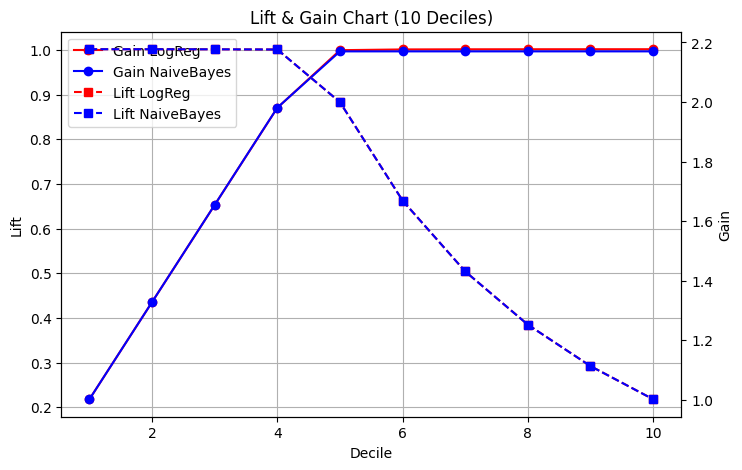

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# Gain
ax1.plot(np.arange(1, 11), gain_lg, marker="o", color="red", label="Gain LogReg")
ax1.plot(np.arange(1, 11), gain_nb, marker="o", color="blue", label="Gain NaiveBayes")

# Lift
ax2.plot(np.arange(1, 11), lift_lg, marker="s", linestyle="--", color="red", label="Lift LogReg")
ax2.plot(np.arange(1, 11), lift_lg, marker="s", linestyle="--", color="blue", label="Lift NaiveBayes")

ax1.set_xlabel("Decile")
ax1.set_ylabel("Gain", color="k")
ax2.set_ylabel("Lift", color="k")
ax1.set_title("Lift & Gain Chart (10 Deciles)")

ax1.grid(True)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()



Almost all positives have been found very quick in first 5 decimiles in both cases. Such a good behaviour may explained by problem simplicity - only 2 classes and approximately 270 examples.

# **MNIST case**

In [14]:
from sklearn.datasets import fetch_openml

x_mnist, y_mnist_raw = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y_mnist = y_mnist_raw.astype(int)

In [15]:
x_mnist_train, x_mnist_test, y_mnist_train, y_mnist_test = train_test_split( x_mnist, y_mnist, test_size=0.2, random_state=29, stratify=y_mnist)

In [16]:
from sklearn.naive_bayes import MultinomialNB

logreg = LogisticRegression(max_iter=500, random_state=29, multi_class='multinomial', solver='lbfgs')
bayes_Mult = MultinomialNB()

In [17]:
logreg.fit(x_mnist_train, y_mnist_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, multi_class='multinomial', random_state=29)

In [18]:
bayes_Mult.fit(x_mnist_train, y_mnist_train)

MultinomialNB()

In [19]:
ac_set = [accuracy_score(y_mnist_train, logreg.predict(x_mnist_train)),
          accuracy_score(y_mnist_train, bayes_Mult.predict(x_mnist_train)),

          accuracy_score(y_mnist_test, logreg.predict(x_mnist_test)),
          accuracy_score(y_mnist_test, bayes_Mult.predict(x_mnist_test)) ]

print(ac_set)

[0.9427678571428572, 0.8285535714285714, 0.9113571428571429, 0.8214285714285714]


In [20]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(y_mnist_train, classes=range(10))
y_test = label_binarize(y_mnist_test, classes=range(10))

auc_set = [roc_auc_score(y_train, logreg.predict_proba(x_mnist_train), average='macro'),
           roc_auc_score(y_train, bayes_Mult.predict_proba(x_mnist_train), average='macro'),

          roc_auc_score(y_test, logreg.predict_proba(x_mnist_test), average='macro'),
           roc_auc_score(y_test, bayes_Mult.predict_proba(x_mnist_test), average='macro')]

In [29]:
G_lg, L_lg = [], []
G_nb, L_nb = [], []


for c in range(10):
  gain_lg = []
  gain_nb = []

  y_true = (y_mnist == c).astype(int)
  l = len(y_true)//10

  y_lg_pred = logreg.predict_proba(x_mnist)[:,c]
  y_nb_pred = bayes_Mult.predict_proba(x_mnist)[:,c]

  ord_lg = np.argsort(y_lg_pred)[::-1]
  ord_nb = np.argsort(y_nb_pred)[::-1]
  Y_lg = y_true[ord_lg]
  N_lg = Y_lg.sum()
  Y_nb = y_true[ord_nb]
  N_nb = Y_nb.sum()

  Y_pred_lg = y_lg_pred[ord_lg]
  Y_pred_nb = y_nb_pred[ord_nb]

  for i in range(10):
    if i < 9:
      gain_lg.append(Y_lg[l * i : l * (i+1)].sum() / N_lg)
      gain_nb.append(Y_nb[l * i : l * (i+1)].sum() / N_nb)
    else:
      gain_lg.append(Y_lg[l * i : ].sum() / N_lg)
      gain_nb.append(Y_nb[l * i : ].sum() / N_nb)

  gain_lg = np.array(gain_lg).cumsum()
  G_lg.append(gain_lg)
  lift_lg = gain_lg / (0.1*np.arange(1, 11))
  L_lg.append(lift_lg)

  gain_nb = np.array(gain_nb).cumsum()
  G_nb.append(gain_nb)
  lift_nb = gain_nb / (0.1*np.arange(1, 11))
  L_nb.append(lift_nb)

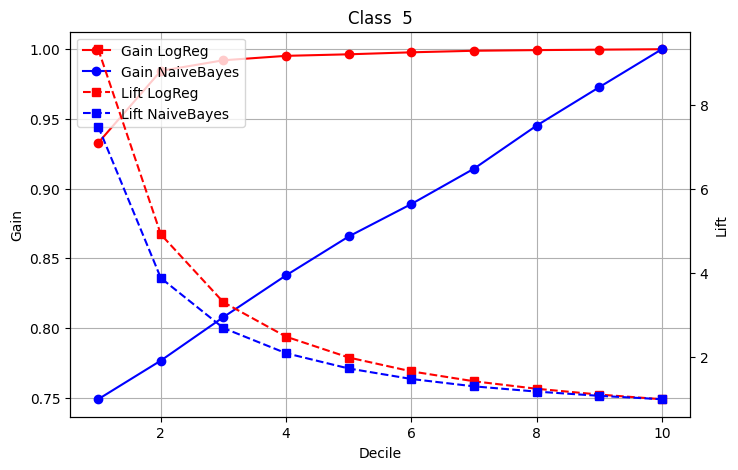

In [34]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
i = 5

# Gain
ax1.plot(np.arange(1, 11), G_lg[i], marker="o", color="red", label="Gain LogReg")
ax1.plot(np.arange(1, 11), G_nb[i], marker="o", color="blue", label="Gain NaiveBayes")

# Lift
ax2.plot(np.arange(1, 11), L_lg[i], marker="s", linestyle="--", color="red", label="Lift LogReg")
ax2.plot(np.arange(1, 11), L_nb[i], marker="s", linestyle="--", color="blue", label="Lift NaiveBayes")

ax1.set_xlabel("Decile")
ax1.set_ylabel("Gain", color="k")
ax2.set_ylabel("Lift", color="k")
ax1.set_title("Class  "+str(i))

ax1.grid(True)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()

According to this graph (which is typical) ona can say that LogReg model solves classification problem is much better than Naive Bayes. Last one is almost random.